In [28]:
from tqdm import tqdm

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import re
import bs4

import spacy
from spacy import displacy
nlp=spacy.load('en_core_web_sm')
from spacy.matcher import Matcher 
from spacy.tokens import Span 

In [29]:
spacy.__version__

'3.5.3'

In [30]:
user_persona = pd.read_json("../data/tech_career_track.json")
user_persona.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   career track    6 non-null      object
 1   attribute 1     6 non-null      object
 2   attribute 2     6 non-null      object
 3   attribute 3     6 non-null      object
 4   special traits  6 non-null      object
 5   tech or stack   6 non-null      object
dtypes: object(6)
memory usage: 416.0+ bytes


In [31]:
user_persona

,career track,attribute 1,attribute 2,attribute 3,special traits,tech or stack
0,front-end developer,creative,problem solver,logical thinker,,"[frontend, html, css, javascript]"
1,back-end developer,logical thinker,problem solver,analytical,,"[backend, database, python, nodejs]"
2,machine learning / data scientist,analytical,problem solver,data-driven,mathematical inclined,"[data, data-science, machine-learning, python]"
3,cloud developer,problem solver,logical thinker,analytical,infrastructure,"[cloud, devops, microservice, architecture]"
4,mobile developer,creative,problem solver,user-focused,tech-savvy,"[mobile, multiplatform, android, ios]"
5,ui/ux designer,creative,analytics,user-focused,empathetic,"[figma, research, mockup, wireframe]"


user persona

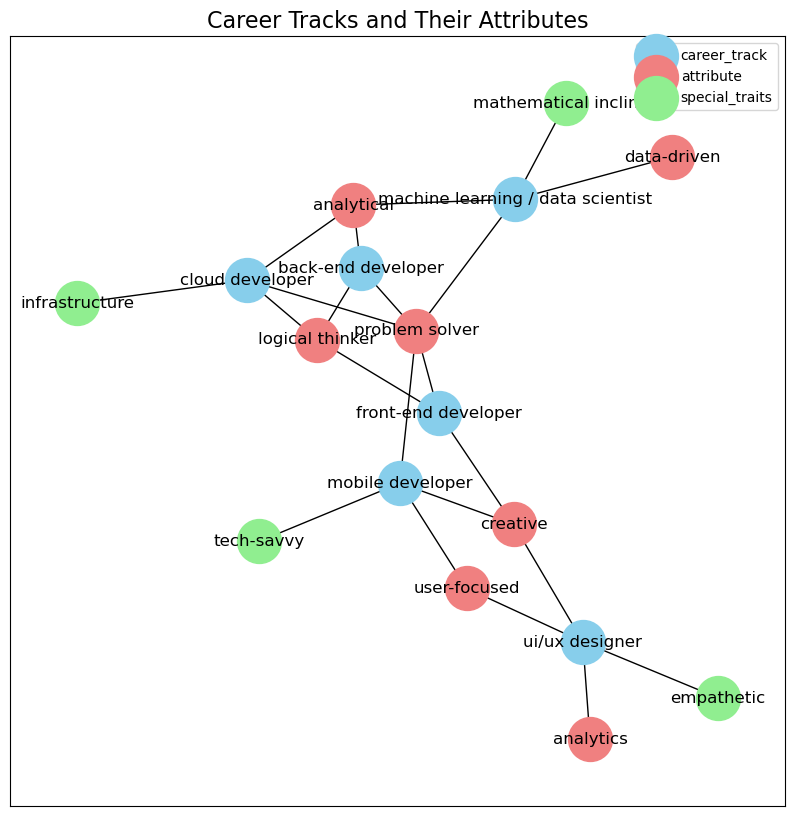

In [32]:
# Create a Pandas DataFrame from the JSON data
df = pd.DataFrame(user_persona.copy())

# Create a graph
G = nx.Graph()

# Add nodes (career tracks) to the graph
for career_track in df["career track"]:
    G.add_node(career_track, type="career_track")

# Add nodes (attributes) to the graph and connect them to career tracks
for index, row in df.iterrows():
    career_track = row["career track"]
    attributes = row[["attribute 1", "attribute 2", "attribute 3"]]
    special_traits = row["special traits"]
    for attribute in attributes:
        G.add_node(attribute, type="attribute")
        G.add_edge(career_track, attribute)
    if special_traits:
        G.add_node(special_traits, type="special_traits")
        G.add_edge(career_track, special_traits)

# Define node colors based on node types
node_colors = {
    "career_track": "skyblue",
    "attribute": "lightcoral",
    "special_traits": "lightgreen",
}

# Draw the graph with specified node colors
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 10))

for node_type, color in node_colors.items():
    nodes = [node for node, data in G.nodes(data=True) if data["type"] == node_type]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_size=1000, node_color=color, label=node_type)

nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)

plt.title("Career Tracks and Their Attributes", fontsize=16)
plt.legend(loc="upper right")
plt.show()


career persona

In [33]:
career_persona = pd.read_json("../data/career_persona.json")
career_persona

,question,trait,answer
0,1,creative,They would describe me as someone with an imag...
1,1,creative,Friends and family often see me as a creative ...
2,1,creative,They might describe me as the family's creativ...
3,1,creative,My loved ones often label me as a creative ind...
4,1,creative,I'm often seen as the creative spark in our fa...
...,...,...,...
121,6,analytical,I prioritize conducting thorough testing and q...
122,6,analytical,I focus on effective marketing and promotion s...
123,6,analytical,I plan for regular updates and enhancements to...
124,6,analytical,Monetization strategies are considered to sust...


In [34]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [35]:
get_entities(career_persona.iloc[0,2])

['They', 'innovative  ideas']

In [36]:
import spacy
from spacy.matcher import Matcher

# Load the spaCy language model
nlp = spacy.load("en_core_web_sm")

def get_relation(sent):
    doc = nlp(sent)

    # Matcher class object
    matcher = Matcher(nlp.vocab)

    # Define the pattern
    pattern = [{'DEP':'ROOT'},
               {'DEP':'prep','OP':"?"},
               {'DEP':'agent','OP':"?"},  
               {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern])  # Note the change here

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return span.text


In [37]:
def get_kg_trait(data, trait):
    if trait == None:
        data = data
    else:
        data = data[data.trait==trait]
    relations = [get_relation(i) for i in tqdm(data.answer)]
    
    entity_pairs = []

    for i in tqdm(data["answer"]):
      entity_pairs.append(get_entities(i))
        
        
    # extract subject
    source = [i[0] for i in entity_pairs]
    
    # extract object
    target = [i[1] for i in entity_pairs]
    
    kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
    
    
    return kg_df

def viz_kg(data):
    # create a directed-graph from a dataframe
    G=nx.from_pandas_edgelist(data, "source", "target", 
                              edge_attr=True, create_using=nx.MultiDiGraph())
    plt.figure(figsize=(15,15))
    
    pos = nx.spring_layout(G)
    
    nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
    # Extract edge labels from the dataframe
    edge_labels = {(row["source"], row["target"]): row["edge"] for _, row in data.iterrows()}
    
    # Draw edge labels on the graph
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    
    

In [38]:
relations = [get_relation(i) for i in tqdm(career_persona.answer)]
relations

100%|██████████| 126/126 [00:00<00:00, 131.41it/s]


['describe',
 'see',
 'describe',
 'label',
 'seen as',
 'describe',
 'see',
 'choose',
 'be',
 'enroll in',
 'be perfect',
 'opt for',
 'inspire',
 'drawn to',
 'appeal to',
 'find',
 "'m",
 'Tasks',
 'Tasks',
 'Tasks',
 'see',
 'is in creative',
 'contribute',
 'lies in creative',
 'envision',
 'excel in',
 'shine in',
 'see',
 'be',
 'involves creative',
 'is',
 'includes',
 'enjoy',
 'find',
 'thrive on',
 'thrive on',
 'creating',
 'ensuring',
 'delivering innovative',
 'crafting',
 'is',
 'seen as',
 'labeled as',
 'regarded as',
 'see',
 'choose',
 'be',
 'enroll in',
 'see',
 'opt for',
 'envision',
 'be excited',
 'drawn to',
 'appeal to',
 'find',
 "'m interested",
 'enjoy',
 "'m",
 'find',
 'see',
 'contribute',
 'bring significant',
 'envision',
 'excel in',
 'see',
 'be',
 'involves',
 'thrive on',
 'includes',
 'enjoy',
 'is',
 'ensuring',
 'prioritize',
 'is',
 'focus on effective',
 'plan for regular',
 'describe',
 'recognized as',
 'see',
 'see',
 'describe',
 'apprec

In [39]:
career_persona['answer']

0      They would describe me as someone with an imag...
1      Friends and family often see me as a creative ...
2      They might describe me as the family's creativ...
3      My loved ones often label me as a creative ind...
4      I'm often seen as the creative spark in our fa...
                             ...                        
121    I prioritize conducting thorough testing and q...
122    I focus on effective marketing and promotion s...
123    I plan for regular updates and enhancements to...
124    Monetization strategies are considered to sust...
125    Monetization strategies are considered to sust...
Name: answer, Length: 126, dtype: object

In [40]:
pd.Series(relations).value_counts()

see                      12
be                        9
find                      9
describe                  6
is                        5
'm                        5
drawn to                  4
envision                  4
contribute                4
enjoy                     4
prioritize                3
Tasks                     3
be excited                3
enroll in                 3
choose                    3
appeal to                 3
thrive on                 3
considered                2
focus on effective        2
'm interested             2
plan for regular          2
ensuring                  2
seeking                   2
includes                  2
seen as                   2
excel in                  2
opt for                   2
involves                  2
is in                     1
place great               1
motivated by              1
appreciate                1
recognized as             1
take                      1
'm keen                   1
motivated           

In [41]:

entity_pairs = []

for i in tqdm(career_persona["answer"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 126/126 [00:00<00:00, 154.55it/s]


In [42]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [43]:
kg_df

,source,target,edge
0,They,innovative ideas,describe
1,creative who,fresh situation,see
2,They,new myself,describe
3,I,everything,label
4,I,inventive challenges,seen as
...,...,...,...
121,thorough quality that,meticulous testing methodologies,prioritize
122,I,marketing marketing campaigns,focus on effective
123,I,new feature development,plan for regular
124,Monetization strategies,positive data monetization,considered


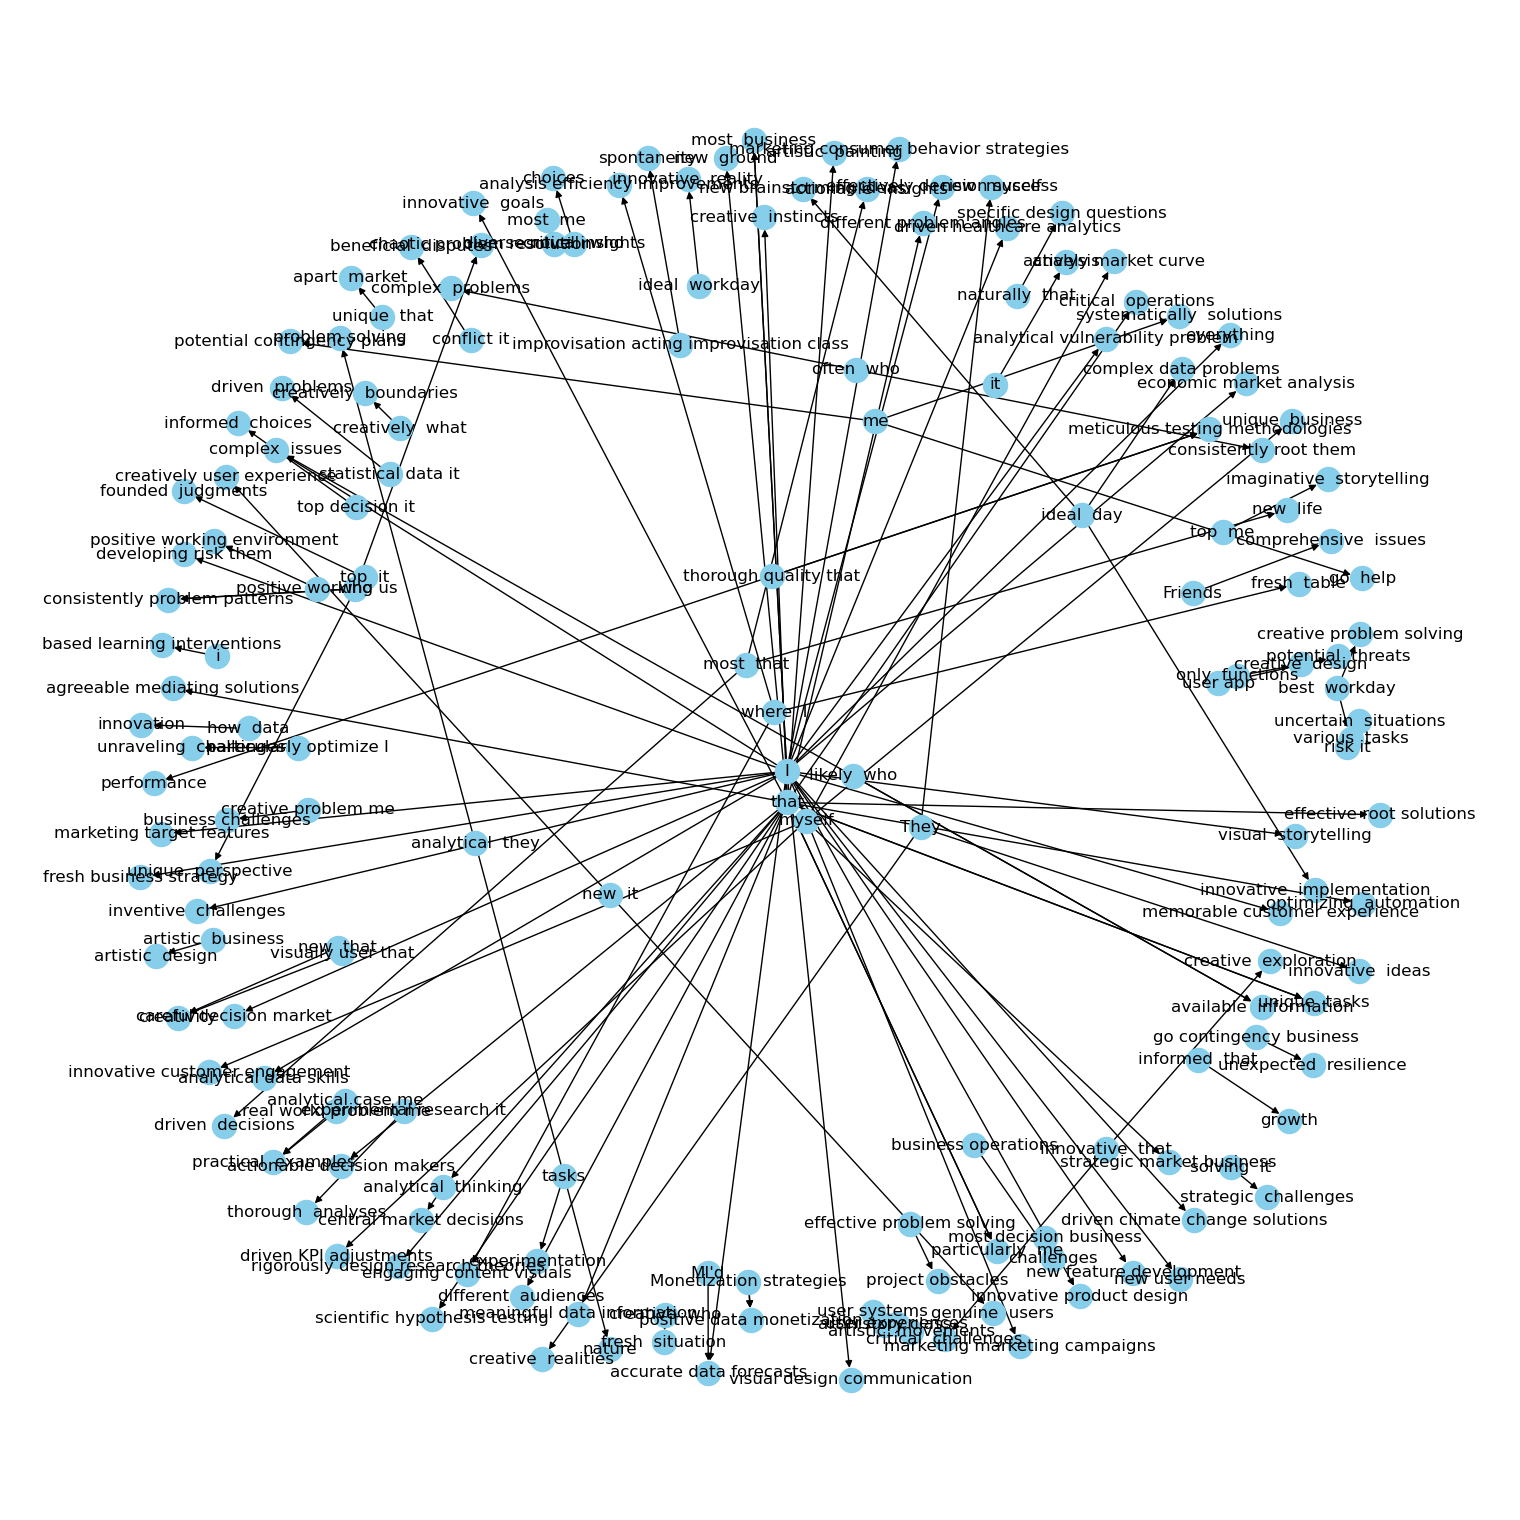

In [44]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(15,15))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [45]:
all_data = get_kg_trait(career_persona, trait = None)


100%|██████████| 126/126 [00:00<00:00, 157.84it/s]


In [46]:
top_edge = all_data.edge.value_counts().index[:20]

In [47]:
creative = get_kg_trait(career_persona,"creative")
creative.edge.value_counts()

100%|██████████| 41/41 [00:00<00:00, 162.83it/s]


edge
see                      4
describe                 3
Tasks                    3
be                       2
thrive on                2
find                     2
is                       2
involves creative        1
excel in                 1
shine in                 1
includes                 1
lies in creative         1
enjoy                    1
creating                 1
ensuring                 1
delivering innovative    1
envision                 1
is in creative           1
contribute               1
'm                       1
appeal to                1
drawn to                 1
inspire                  1
opt for                  1
be perfect               1
enroll in                1
choose                   1
seen as                  1
label                    1
crafting                 1
Name: count, dtype: int64

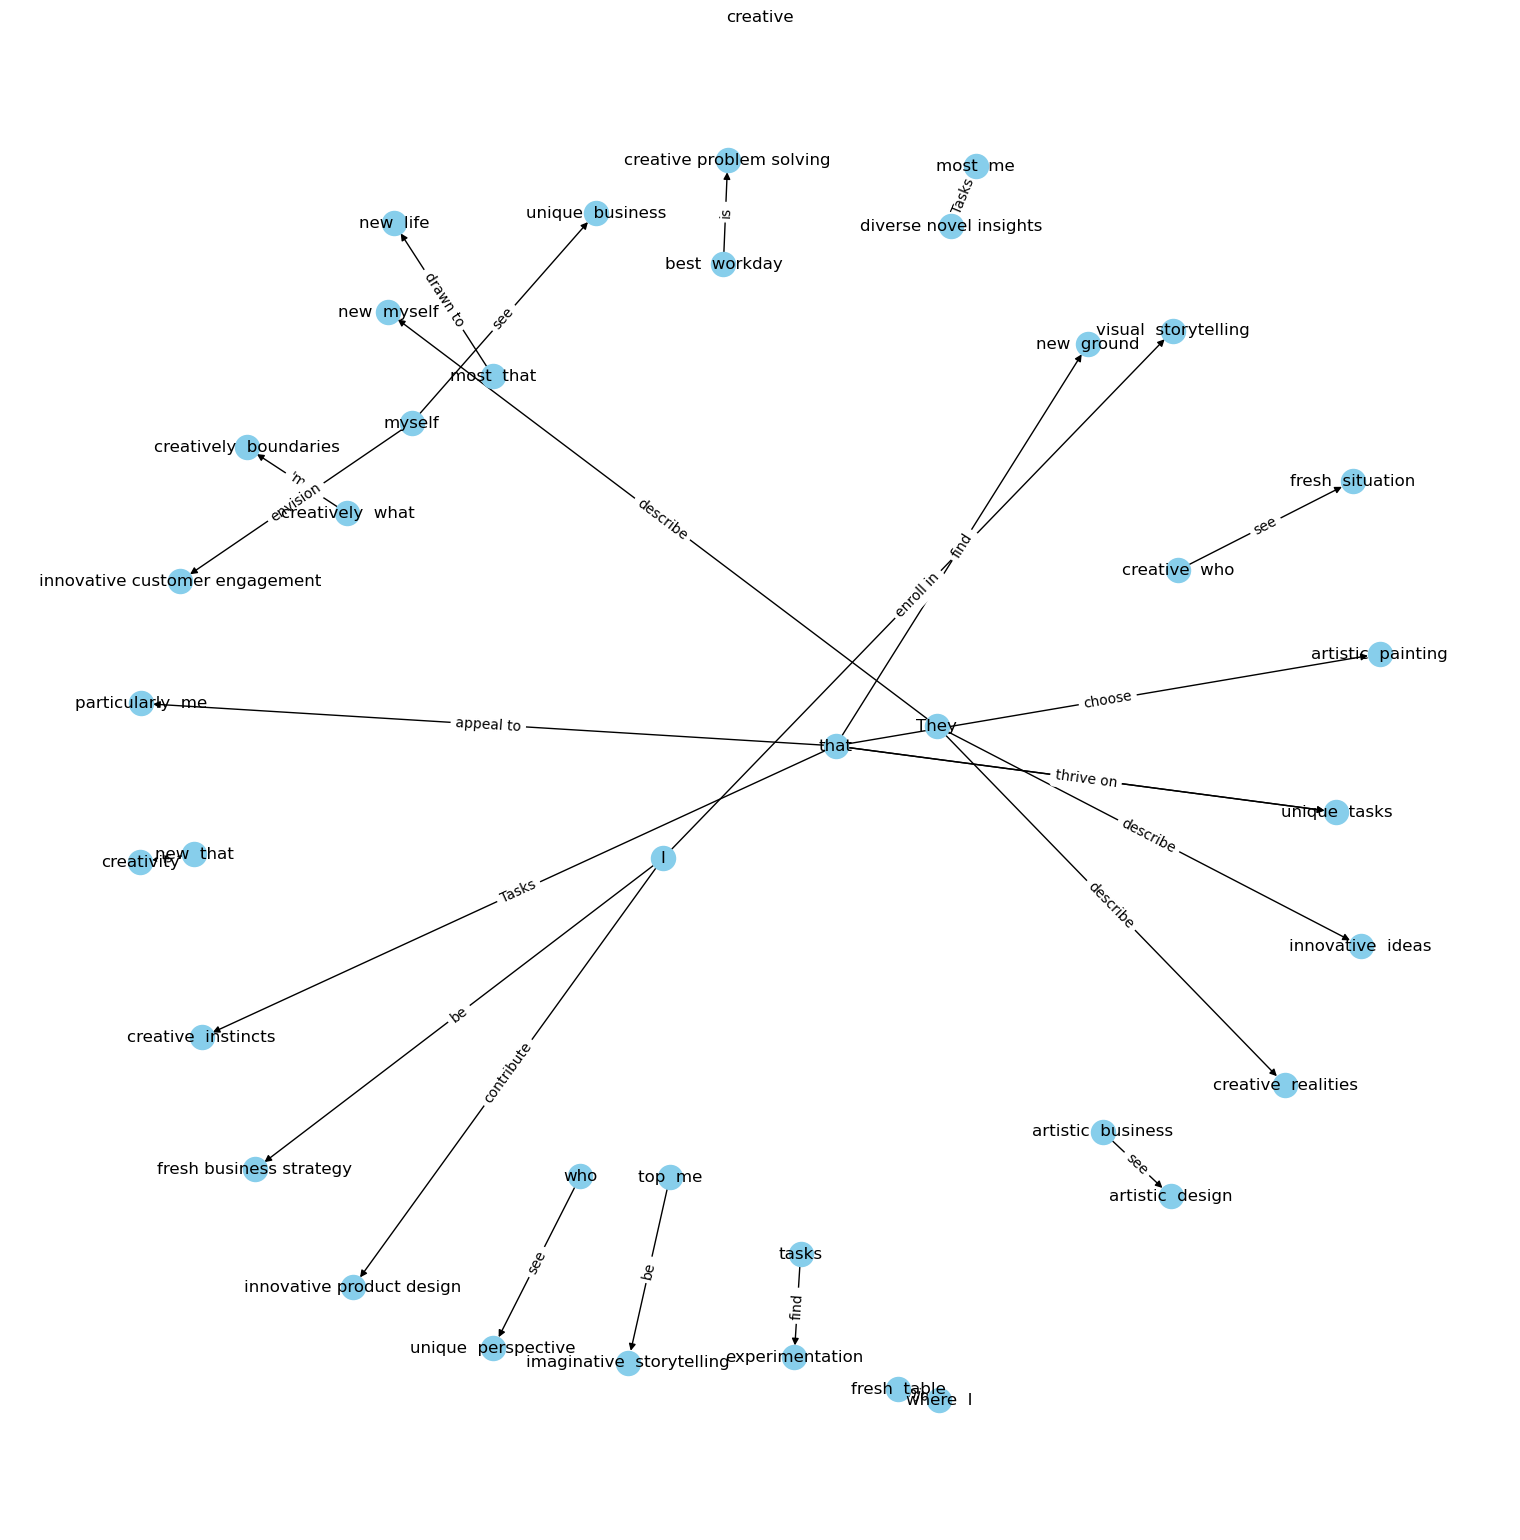

In [48]:
viz_kg(creative[creative.edge.isin(top_edge)])
plt.title("creative")
plt.show()

In [49]:
plt.show()
problem_solver = get_kg_trait(career_persona, "problem solver")
problem_solver.edge.value_counts()

100%|██████████| 35/35 [00:00<00:00, 160.80it/s]


edge
see                   4
be                    2
is                    2
envision              2
find                  2
enjoy                 2
seen as               1
contribute            1
focus on effective    1
prioritize            1
ensuring              1
includes              1
thrive on             1
involves              1
excel in              1
bring significant     1
'm interested         1
'm                    1
labeled as            1
appeal to             1
drawn to              1
be excited            1
opt for               1
enroll in             1
choose                1
regarded as           1
plan for regular      1
Name: count, dtype: int64

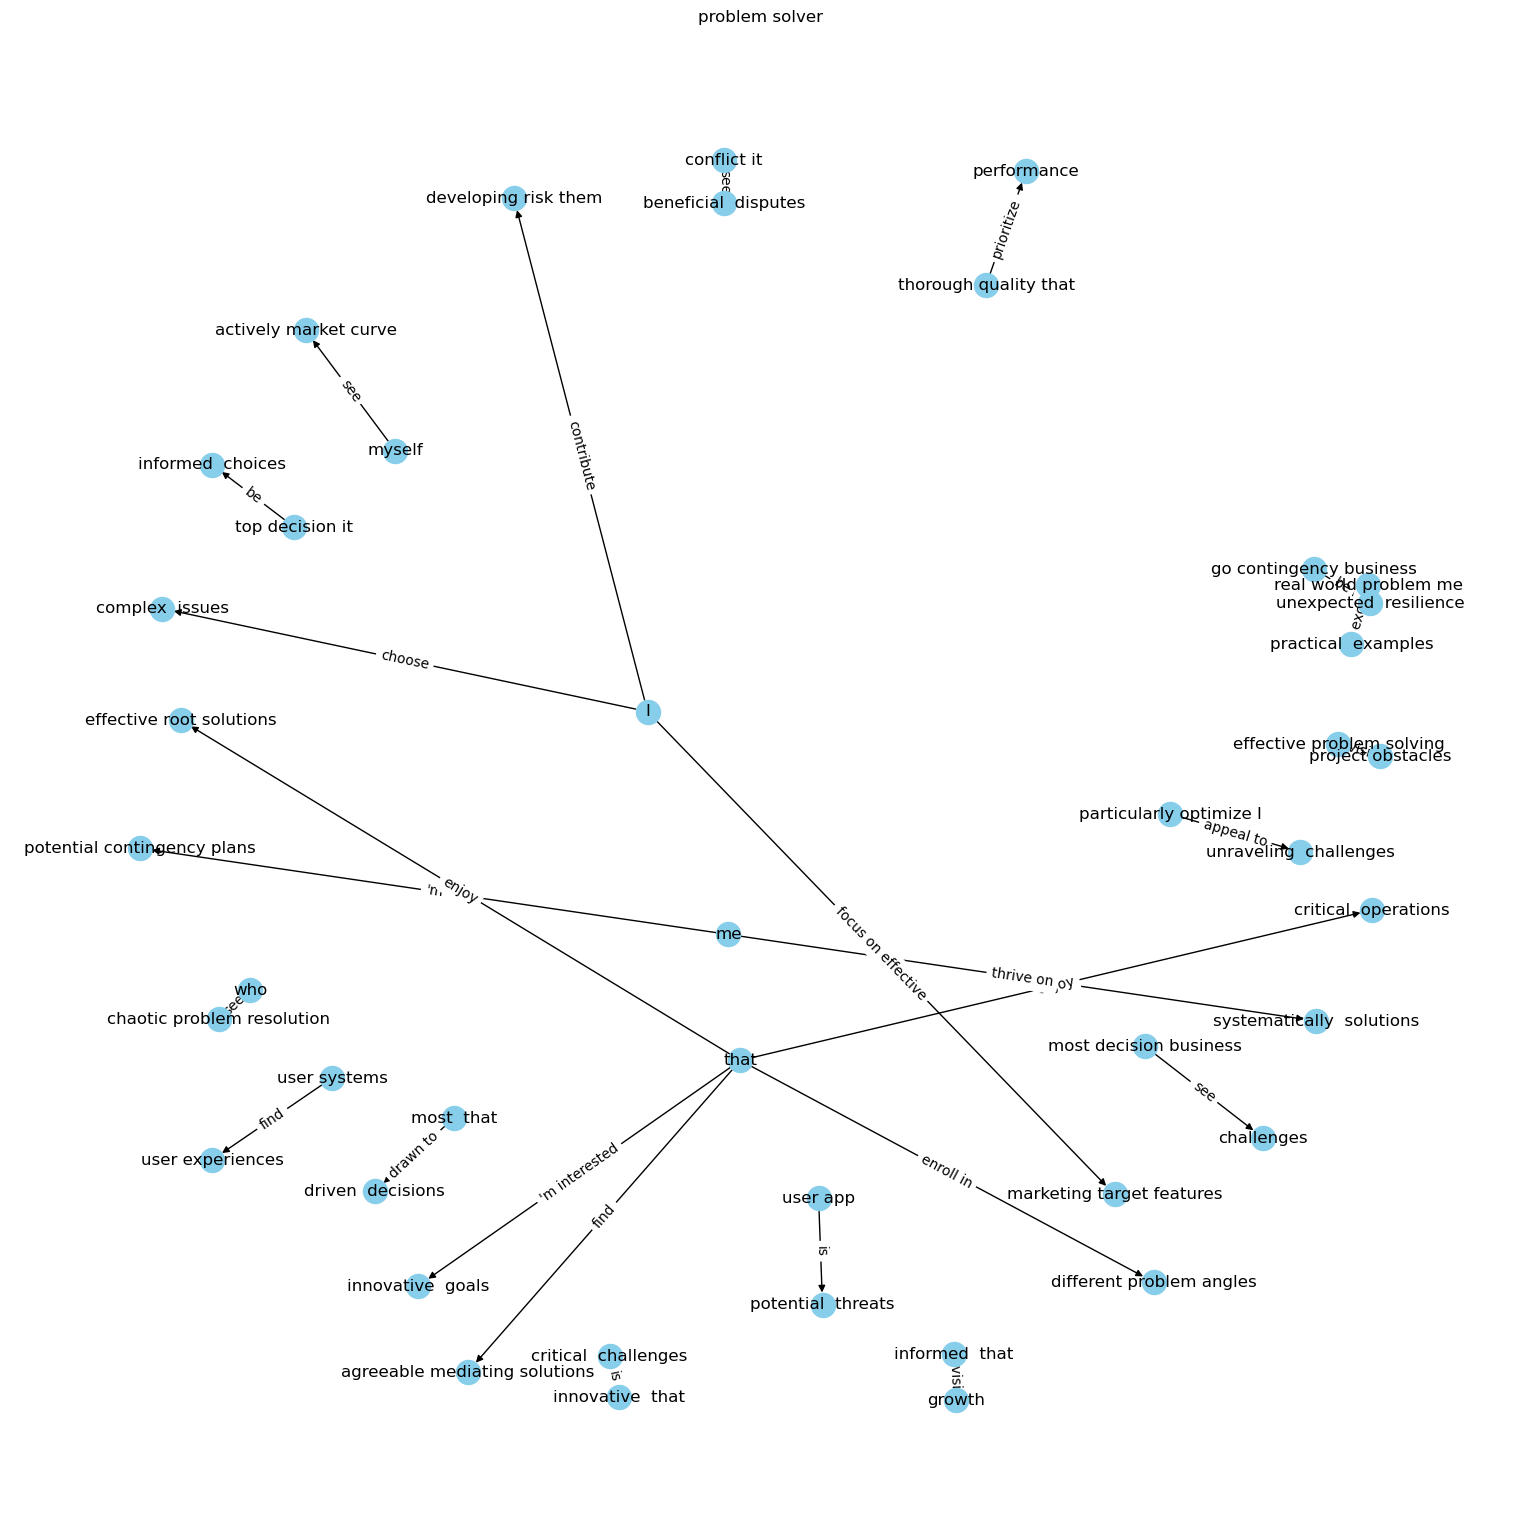

In [50]:
viz_kg(problem_solver[problem_solver.edge.isin(top_edge)])
plt.title("problem solver")
plt.show()

In [51]:
analytical = get_kg_trait(career_persona,"analytical")
analytical.edge.value_counts()

100%|██████████| 50/50 [00:00<00:00, 149.05it/s]


edge
be                    5
find                  5
see                   4
describe              3
'm                    3
drawn to              2
prioritize            2
seeking               2
contribute            2
be excited            2
considered            2
'm interested         1
enroll in             1
plan for regular      1
focus on effective    1
appreciate            1
motivated             1
'm keen               1
take                  1
motivated by          1
enjoy                 1
appeal to             1
involves              1
place great           1
envision              1
is in                 1
recognized as         1
choose                1
is                    1
Name: count, dtype: int64

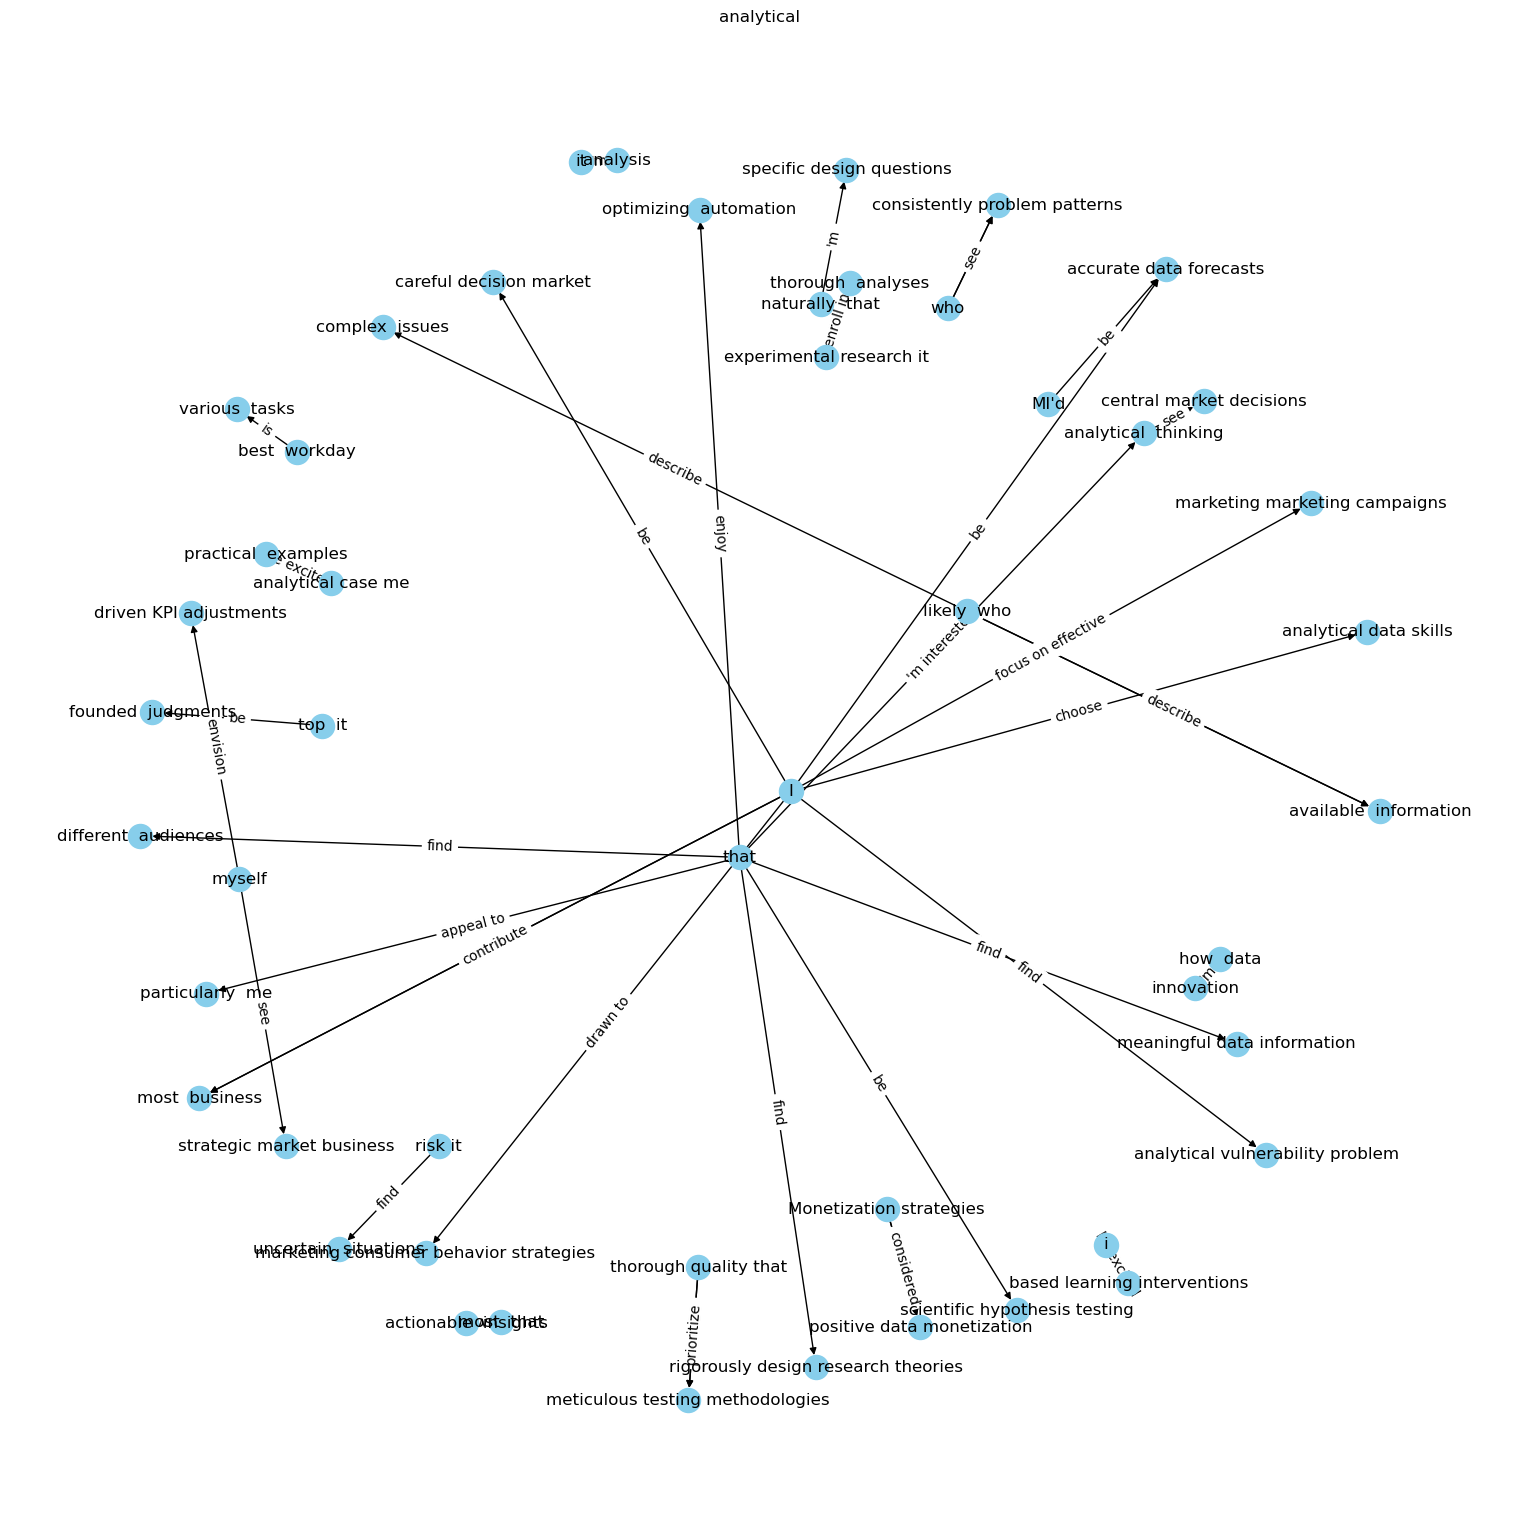

In [53]:
viz_kg(analytical[analytical.edge.isin(top_edge)])
plt.title("analytical")
plt.show()